In [12]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *
from sklearn.feature_selection import RFE

In [104]:
file_path = 'Datasets/cleaned_df_train.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,0.545511,0.545511,0.085140,0.390315,0.482409,0.192358,0.245621,0.252024,0.244859,...,0.000000,0.0,0.0,0,0,0.0,0,0.0,0.000000,0.0
1,1,0.591920,0.591920,0.096454,0.458798,0.634336,0.191751,0.233582,0.228991,0.233545,...,0.000000,0.0,0.0,0,0,0.0,0,0.0,0.000000,0.0
2,1,0.553126,0.553126,0.127622,0.396612,0.448277,0.197788,0.332478,0.339314,0.331164,...,0.000000,0.0,0.0,0,0,0.0,0,0.0,0.000000,0.0
3,0,0.612445,0.612445,0.229406,0.393490,0.609005,0.201896,0.376771,0.367702,0.376548,...,0.707107,0.0,0.0,0,0,0.0,0,0.0,0.223607,0.0
4,0,0.618170,0.618170,0.348463,0.255153,0.101525,0.788620,1.000000,0.992390,1.000000,...,0.000000,0.0,0.0,0,0,0.0,0,0.0,0.000000,0.0


In [107]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [106]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1782, 198)
Shape of X_test: (446, 198)
Shape of y_train: (1782,)
Shape of y_test: (446,)


In [110]:
file_path = 'Datasets/cleaned_df_test.xlsx'
df2 = pd.read_excel(file_path)
df2.shape

(259, 203)

In [111]:
df2 = df2[df.columns]  # Keep only columns that exist in df

In [112]:
df2.to_excel("Features/selected_features_CorrVar_test.xlsx", index=False)

## Correlation + Variation

In [108]:
def feature_selection(df):
    nonzero_thrd=0.01
    cor_thrd=0.9
    print(f"Original shape of data: {df.shape}")
    
    # Step 1: Remove features with low variance
    nonzero_df = df.loc[:, df.var() > nonzero_thrd]
    print(f"Removed {df.shape[1] - nonzero_df.shape[1]} features with variance <= {nonzero_thrd}")
    
    # Step 2: Remove highly correlated features
    corr_matrix = nonzero_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_thrd)]
    print(f"Removed {len(to_drop)} highly correlated features with correlation > {cor_thrd}")
    
    # Step 3: Return the cleaned dataset
    cleaned_df = nonzero_df.drop(to_drop, axis=1)
    print(f"Final shape of data: {cleaned_df.shape}")
    return cleaned_df


df_cleaned = feature_selection(df)
df = feature_selection(df)
CorrVar_selected_features = list(df_cleaned.columns)

Original shape of data: (2228, 199)
Removed 53 features with variance <= 0.01
Removed 40 highly correlated features with correlation > 0.9
Final shape of data: (2228, 106)
Original shape of data: (2228, 199)
Removed 53 features with variance <= 0.01
Removed 40 highly correlated features with correlation > 0.9
Final shape of data: (2228, 106)


In [109]:
# Convert to DataFrame
df_selected = df[CorrVar_selected_features]

# Export to Excel
df_selected.to_excel("Features/selected_features_CorrVar_train.xlsx", index=False)

## Lasso

In [51]:
# Train a Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

# Get important features (non-zero coefficients)
important_features = X.columns[np.abs(lasso.coef_) > 0]
print("Selected Features:", important_features)



Selected Features: Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MaxAbsPartialCharge',
       'FpDensityMorgan1', 'Chi3n', 'Chi4n', 'Chi4v', 'PEOE_VSA1', 'SMR_VSA5',
       'SlogP_VSA1', 'TPSA', 'EState_VSA1', 'EState_VSA3', 'NOCount',
       'NumHeteroatoms', 'NumRotatableBonds', 'fr_C_O_noCOO', 'fr_ether'],
      dtype='object')


In [52]:
feature_names_Lasso = list(important_features.values)

In [14]:
selected_features = list(important_features.values)
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/selected_features_Lasso.xlsx", index=False)

## Models

In [15]:
def xgboost(X_train, y_train, X_test, y_test):
    # Instantiate the XGBoost classifier
    xgb_model = xgb.XGBClassifier(objective='binary:logistic')

    # Perform cross-validation with 5 folds and accuracy scoring
    cv_results = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

    # Print cross-validation results
    print("Cross-validation results:")
    print(cv_results)
    print("Average Accuracy:", cv_results.mean())

    # Fit the model on the entire training dataset
    xgb_model.fit(X_train, y_train)

    # Evaluate accuracy on test data
    test_accuracy = xgb_model.score(X_test, y_test)
    train_accuracy = xgb_model.score(X_train, y_train)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    return xgb_model

In [16]:
def random_forest(X_train, y_train, X_test, y_test):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier()

    # Cross-validation
    cv_results = cross_val_score(rf, X_train, y_train, cv=5)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return rf

In [17]:
def decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier()
    
    # Cross-validation
    cv_results = cross_val_score(dt, X_train, y_train, cv = 5)
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = dt.predict(X_test)
    y_pred_train = dt.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return dt
    

In [18]:
def k_neigbhors(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier()

    cv_results = cross_val_score(knn, X_train, y_train, cv=5)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return knn

In [19]:
def Support_vector_machine(X_train, y_train, X_test, y_test):
    svm= SVC()

    cv_results = cross_val_score(svm, X_train, y_train, cv=5)
    svm.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = svm.predict(X_test)
    y_pred_train = svm.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    return svm

In [20]:
print("XGBoost:")
xgb_model = xgboost(X_train, y_train, X_test, y_test)
print("\nRandom forest:")
rf_model = random_forest(X_train, y_train, X_test, y_test)
print("\nDecision tree:")
dt_model = decision_tree(X_train, y_train, X_test, y_test)
print("\nKNN:")
knn_model = k_neigbhors(X_train, y_train, X_test, y_test)
print("\nSVM")
svm_model = Support_vector_machine(X_train, y_train, X_test, y_test)

XGBoost:
Cross-validation results:
[0.75376884 0.71356784 0.73366834 0.74120603 0.76322418]
Average Accuracy: 0.7410870473273168
Train Accuracy: 1.0
Test Accuracy: 0.7590361445783133

Random forest:
Cross-validation results: [0.74371859 0.72110553 0.72361809 0.75376884 0.73551637]
Average Accuracy: 0.7355454856144703
Train Accuracy: 1.0
Test Accuracy: 0.7389558232931727

Decision tree:
Cross-validation results: [0.68090452 0.66080402 0.62562814 0.65075377 0.63979849]
Average Accuracy: 0.6515777881852588
Train Accuracy: 1.0
Test Accuracy: 0.6686746987951807

KNN:
Cross-validation results: [0.6959799  0.66080402 0.68341709 0.71105528 0.69269521]
Average Accuracy: 0.6887902991025657
Train Accuracy: 0.7943690296631473
Test Accuracy: 0.6666666666666666

SVM
Cross-validation results: [0.74623116 0.70351759 0.74874372 0.74623116 0.73047859]
Average Accuracy: 0.7350404415022215
Train Accuracy: 0.792357968828557
Test Accuracy: 0.7269076305220884


## RFE Logistic Regression

In [79]:
RFE_Features_selection = []

In [83]:
def LR_find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):  
    validation_accuracies = []
    train_accuracies = []

    # Train a Logistic Regression model
    model = LogisticRegression(max_iter=500)

    for num_features in range(1, max_features + 1):
        rfe = RFE(model, n_features_to_select=num_features)
        rfe.fit_transform(X_train, y_train)

        selected_features = X_train.columns[rfe.support_]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")


    rfe = RFE(model, n_features_to_select=optimal_num_features)
    X_selected = rfe.fit_transform(X, y)

    selected_features = X.columns[rfe.support_]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

1
Cross-validation results: [0.66582915 0.64321608 0.65075377 0.66080402 0.63979849]
Average Accuracy: 0.6520803007480729
Train Accuracy: 1.0
Test Accuracy: 0.6566265060240963


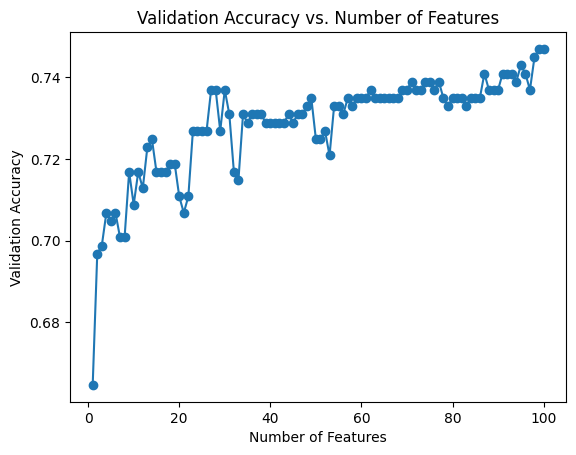

Optimal number of features: 99
2
Cross-validation results: [0.65577889 0.67336683 0.63316583 0.65075377 0.63979849]
Average Accuracy: 0.6505727630596306
Train Accuracy: 1.0
Test Accuracy: 0.6465863453815262


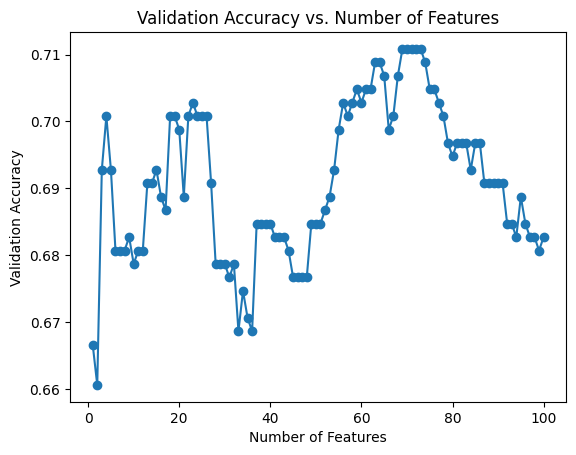

Optimal number of features: 69
3
Cross-validation results: [0.67085427 0.63567839 0.64070352 0.59798995 0.70528967]
Average Accuracy: 0.6501031606394694
Train Accuracy: 1.0
Test Accuracy: 0.6767068273092369


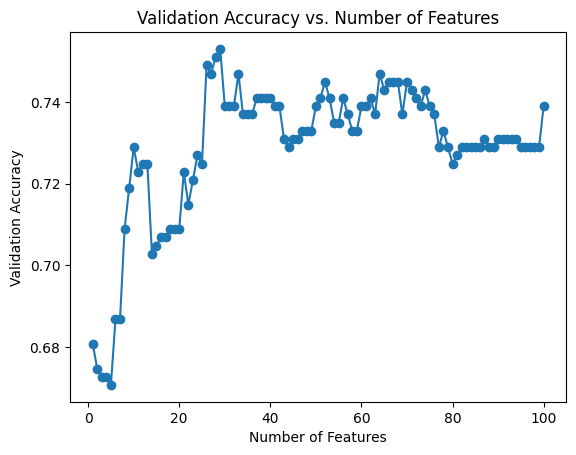

Optimal number of features: 29
4
Cross-validation results: [0.63065327 0.65075377 0.60050251 0.64070352 0.65239295]
Average Accuracy: 0.6350012024859815
Train Accuracy: 1.0
Test Accuracy: 0.6807228915662651


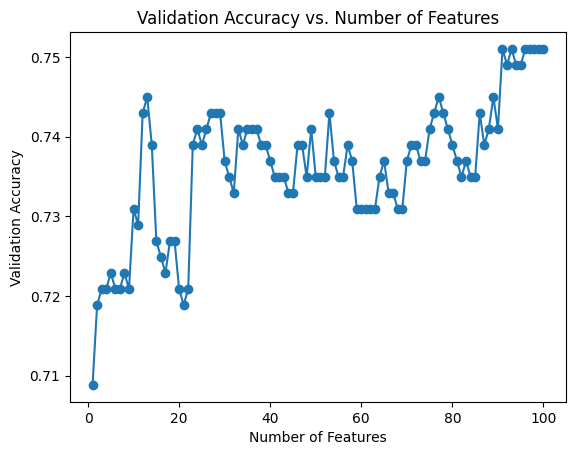

Optimal number of features: 91
5
Cross-validation results: [0.67085427 0.64824121 0.65326633 0.64572864 0.64735516]
Average Accuracy: 0.6530891231978533
Train Accuracy: 1.0
Test Accuracy: 0.6305220883534136


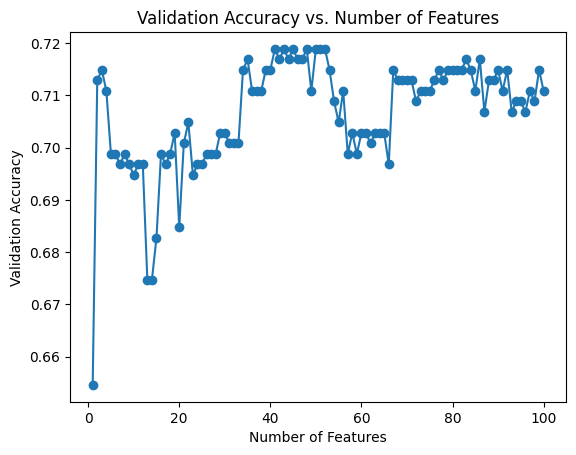

Optimal number of features: 41
6
Cross-validation results: [0.64824121 0.65075377 0.7160804  0.65326633 0.6372796 ]
Average Accuracy: 0.6611242611040087
Train Accuracy: 1.0
Test Accuracy: 0.6305220883534136


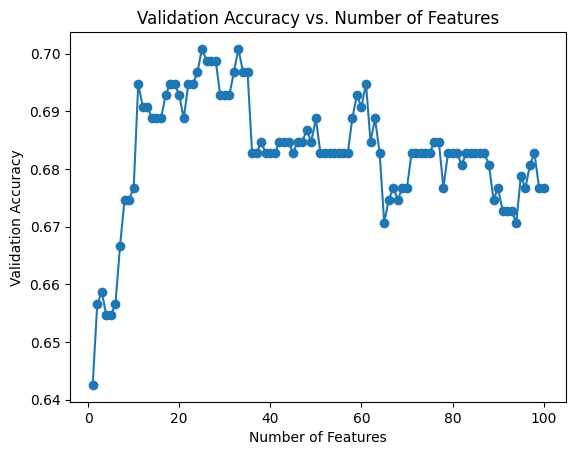

Optimal number of features: 25
7
Cross-validation results: [0.64070352 0.69849246 0.61809045 0.62060302 0.66246851]
Average Accuracy: 0.6480715922180171
Train Accuracy: 1.0
Test Accuracy: 0.6646586345381527


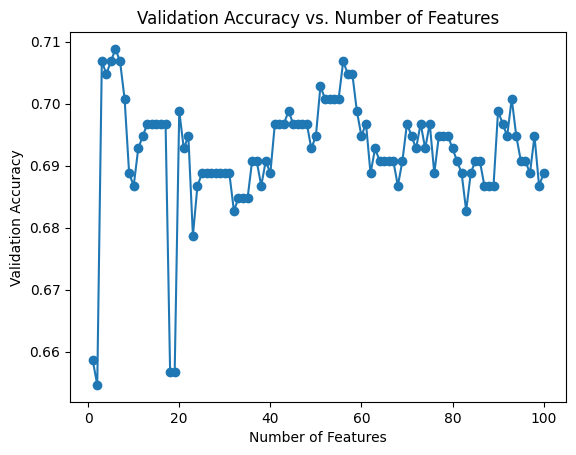

Optimal number of features: 6
8
Cross-validation results: [0.58542714 0.64572864 0.65829146 0.64824121 0.60957179]
Average Accuracy: 0.6294520461248306
Train Accuracy: 1.0
Test Accuracy: 0.6867469879518072


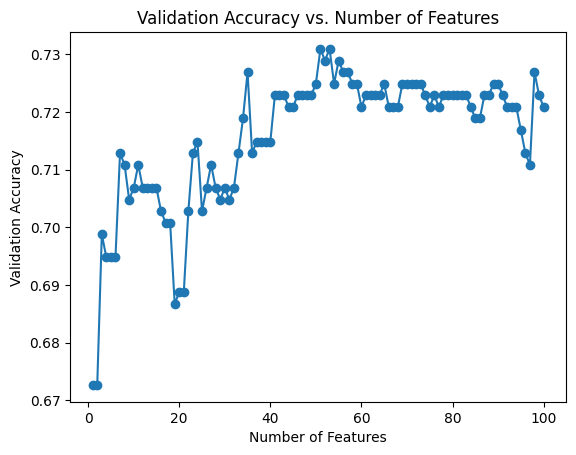

Optimal number of features: 51
9
Cross-validation results: [0.67336683 0.63065327 0.6758794  0.63819095 0.60201511]
Average Accuracy: 0.6440211131222864
Train Accuracy: 1.0
Test Accuracy: 0.6385542168674698


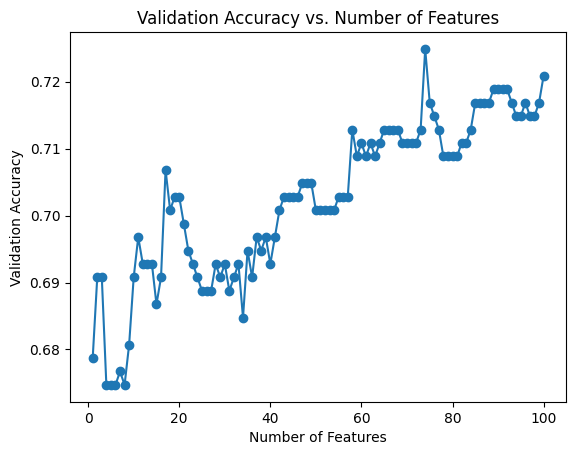

Optimal number of features: 74
10
Cross-validation results: [0.61557789 0.63316583 0.63567839 0.64572864 0.67002519]
Average Accuracy: 0.6400351885371441
Train Accuracy: 1.0
Test Accuracy: 0.6767068273092369


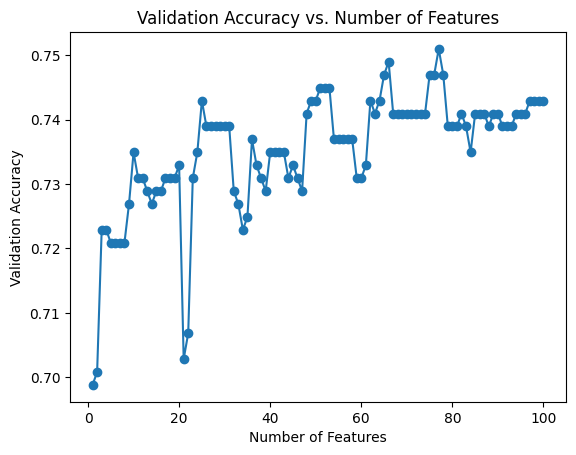

Optimal number of features: 77
11
Cross-validation results: [0.64070352 0.64572864 0.64321608 0.63567839 0.67002519]
Average Accuracy: 0.6470703644165411
Train Accuracy: 1.0
Test Accuracy: 0.6626506024096386


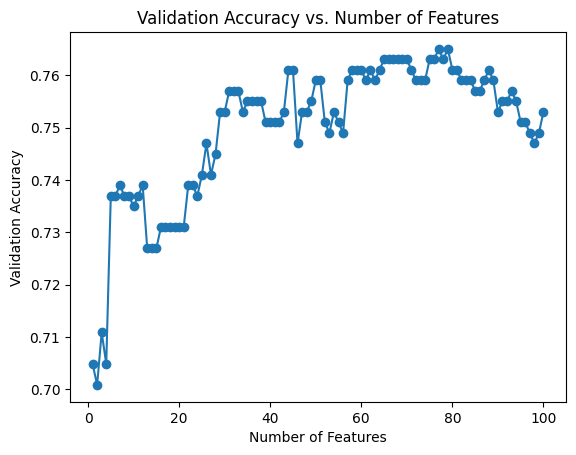

Optimal number of features: 77
12
Cross-validation results: [0.66582915 0.61557789 0.66834171 0.65829146 0.67254408]
Average Accuracy: 0.6561168563219117
Train Accuracy: 1.0
Test Accuracy: 0.6465863453815262


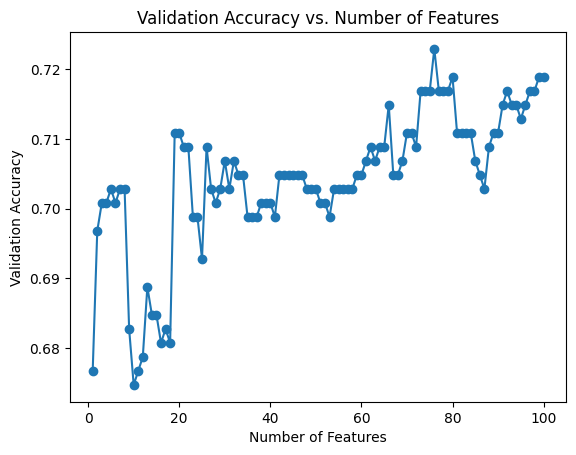

Optimal number of features: 76
13
Cross-validation results: [0.65326633 0.6281407  0.65326633 0.61557789 0.6675063 ]
Average Accuracy: 0.6435515107021252
Train Accuracy: 1.0
Test Accuracy: 0.6204819277108434


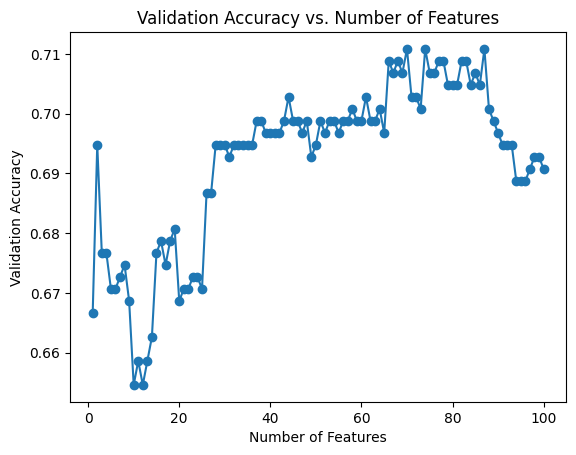

Optimal number of features: 70
14
Cross-validation results: [0.65075377 0.69849246 0.63819095 0.64572864 0.63476071]
Average Accuracy: 0.6535853068870802
Train Accuracy: 1.0
Test Accuracy: 0.6465863453815262


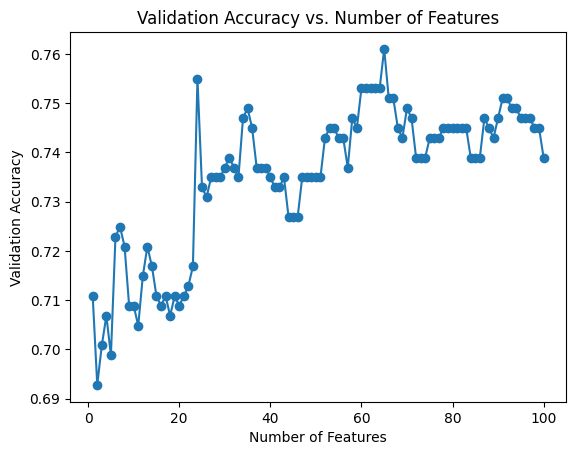

Optimal number of features: 65
15
Cross-validation results: [0.64070352 0.64070352 0.64321608 0.68090452 0.64987406]
Average Accuracy: 0.6510803387213143
Train Accuracy: 1.0
Test Accuracy: 0.6325301204819277


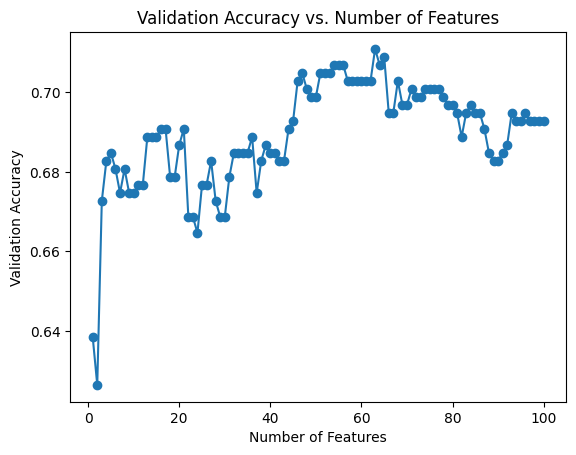

Optimal number of features: 63
16
Cross-validation results: [0.61809045 0.64572864 0.59798995 0.70100503 0.65239295]
Average Accuracy: 0.6430414034910067
Train Accuracy: 1.0
Test Accuracy: 0.6767068273092369


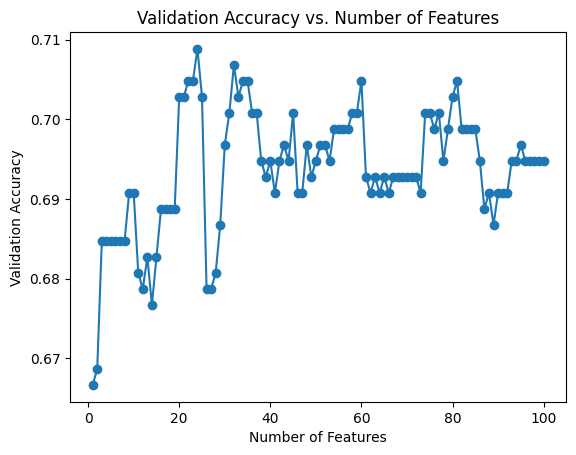

Optimal number of features: 24
17
Cross-validation results: [0.65326633 0.64824121 0.65326633 0.65326633 0.64483627]
Average Accuracy: 0.6505752946090654
Train Accuracy: 1.0
Test Accuracy: 0.6445783132530121


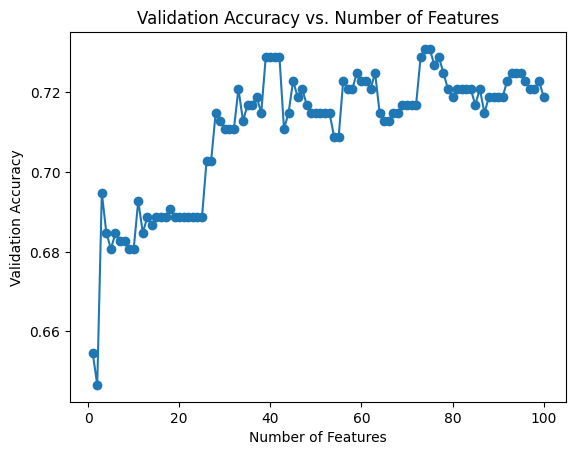

Optimal number of features: 74
18
Cross-validation results: [0.64572864 0.7160804  0.65577889 0.70351759 0.68513854]
Average Accuracy: 0.6812488133362025
Train Accuracy: 1.0
Test Accuracy: 0.6184738955823293


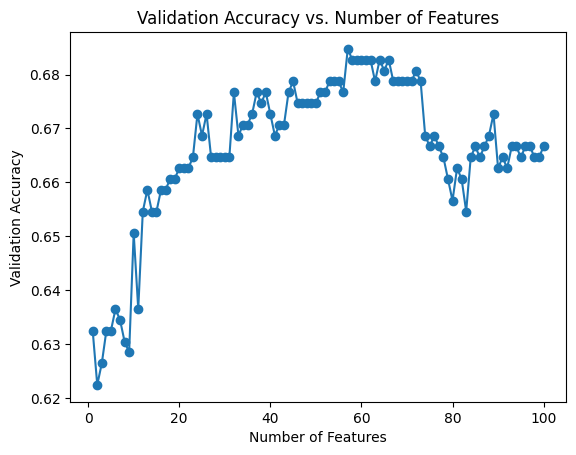

Optimal number of features: 57
19
Cross-validation results: [0.67085427 0.62562814 0.63316583 0.59798995 0.67254408]
Average Accuracy: 0.6400364543118615
Train Accuracy: 1.0
Test Accuracy: 0.6566265060240963


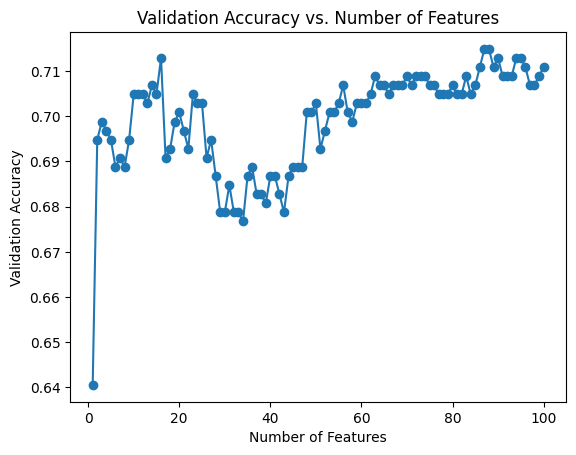

Optimal number of features: 87
20
Cross-validation results: [0.67085427 0.62311558 0.64321608 0.62311558 0.63979849]
Average Accuracy: 0.6400199992405352
Train Accuracy: 1.0
Test Accuracy: 0.6405622489959839


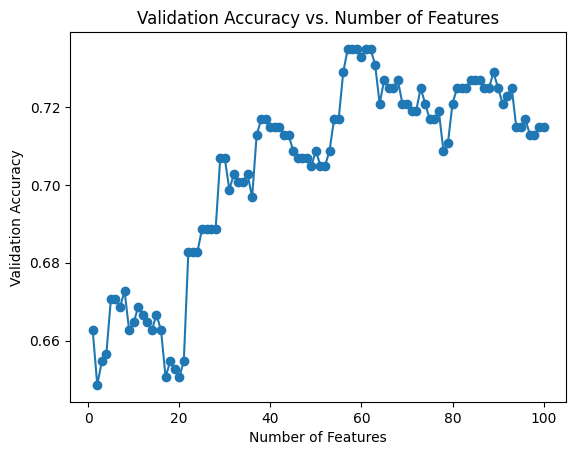

Optimal number of features: 57


In [84]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    dt_model = decision_tree(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = LR_find_best_num_features(X_train, y_train, X_test, y_test, dt_model)
    X_train_selected
    RFE_Features_selection.append(list(X_train_selected.columns))


In [25]:
for i in RFE_Features_selection:
    print(i)

['MinEStateIndex', 'PEOE_VSA10', 'PEOE_VSA9', 'SMR_VSA6', 'TPSA', 'EState_VSA2', 'VSA_EState7', 'fr_alkyl_halide', 'fr_para_hydroxylation']
['MinEStateIndex', 'qed', 'SPS', 'MolWt', 'MinPartialCharge', 'MaxAbsPartialCharge', 'FpDensityMorgan1', 'BalabanJ', 'BertzCT', 'HallKierAlpha', 'Kappa2', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA2', 'PEOE_VSA9', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA6', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA2', 'TPSA', 'EState_VSA10', 'EState_VSA2', 'EState_VSA4', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'FractionCSP3', 'NHOHCount', 'NOCount', 'NumAromaticRings', 'fr_COO', 'fr_C_O', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_aniline', 'fr_bicyclic', 'fr_halogen', 'fr_para_hydroxylation', 'fr_pyridine', 'fr_sulfone']
['MinEStateIndex', 'qed', 'SPS', 'MolWt', 'MinPartialCharge', 'MaxAbsPartialCharge', 'FpDensityMorgan1', 'BalabanJ', 'BertzCT', 'HallKierAlpha', 'Kappa2', 'PEOE_VSA1', 'PEOE_

## Random Forest 

In [85]:
RF_Features_selection = []

In [86]:
def RF_find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):  
    validation_accuracies = []
    train_accuracies = []


    # Train a Random Forest model
    model = RandomForestClassifier()
    model.fit(X, y)

    # Get feature importance
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    for num_features in range(1, max_features + 1):

        selected_features = feature_importances.index[:num_features]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")


    rfe = RFE(model, n_features_to_select=optimal_num_features)
    X_selected = rfe.fit_transform(X, y)

    selected_features = X.columns[rfe.support_]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

1
Cross-validation results: [0.64824121 0.68341709 0.66080402 0.64070352 0.6070529 ]
Average Accuracy: 0.6480437451742339
Train Accuracy: 1.0
Test Accuracy: 0.642570281124498


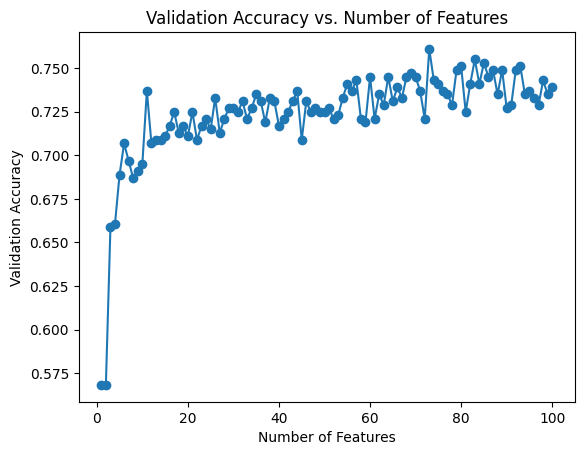

Optimal number of features: 73
2
Cross-validation results: [0.65829146 0.64824121 0.62311558 0.66834171 0.69269521]
Average Accuracy: 0.6581370327709075
Train Accuracy: 1.0
Test Accuracy: 0.6746987951807228


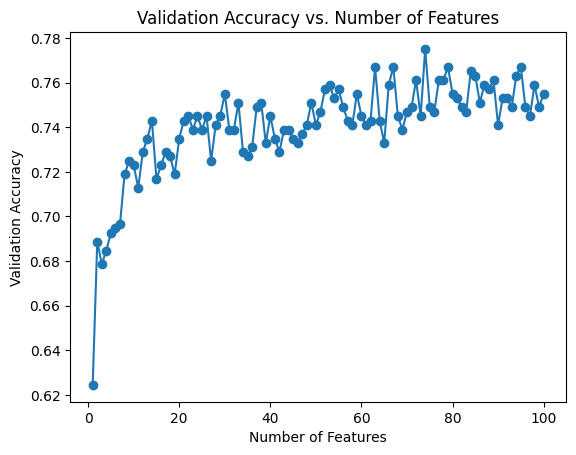

Optimal number of features: 74
3
Cross-validation results: [0.60050251 0.65075377 0.63567839 0.67839196 0.64231738]
Average Accuracy: 0.6415288027036948
Train Accuracy: 1.0
Test Accuracy: 0.6646586345381527


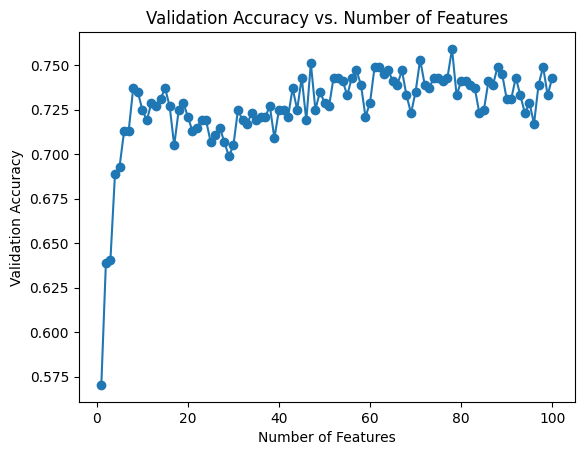

Optimal number of features: 78
4
Cross-validation results: [0.63065327 0.64321608 0.65075377 0.62311558 0.65994962]
Average Accuracy: 0.6415376631267167
Train Accuracy: 1.0
Test Accuracy: 0.6706827309236948


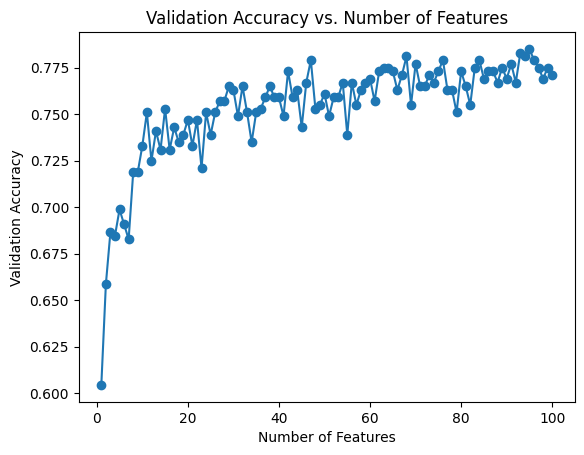

Optimal number of features: 95
5
Cross-validation results: [0.63819095 0.64321608 0.63065327 0.61306533 0.65994962]
Average Accuracy: 0.6370150500613899
Train Accuracy: 1.0
Test Accuracy: 0.6445783132530121


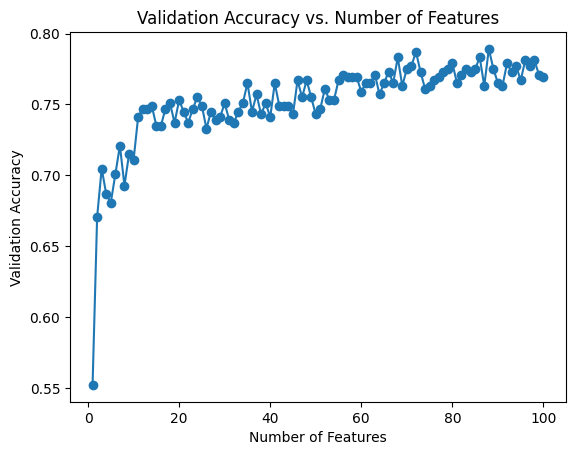

Optimal number of features: 88
6
Cross-validation results: [0.64572864 0.68592965 0.63567839 0.67085427 0.59193955]
Average Accuracy: 0.6460261002746731
Train Accuracy: 1.0
Test Accuracy: 0.6526104417670683


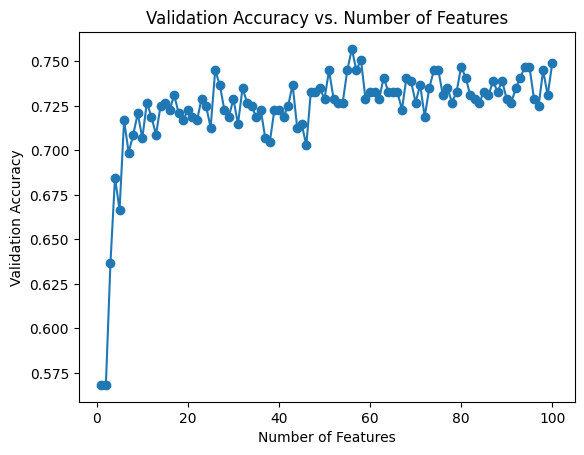

Optimal number of features: 56
7
Cross-validation results: [0.63065327 0.67336683 0.66080402 0.64572864 0.65743073]
Average Accuracy: 0.653596698859537
Train Accuracy: 1.0
Test Accuracy: 0.6746987951807228


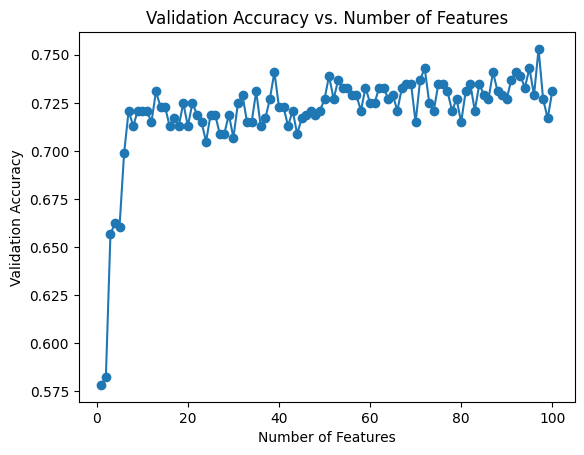

Optimal number of features: 97
8
Cross-validation results: [0.63819095 0.63065327 0.6281407  0.61557789 0.63476071]
Average Accuracy: 0.6294647038720048
Train Accuracy: 1.0
Test Accuracy: 0.6546184738955824


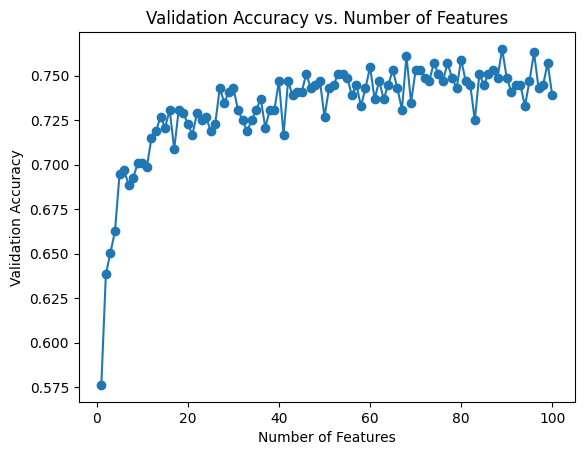

Optimal number of features: 89
9
Cross-validation results: [0.64070352 0.61055276 0.61557789 0.64070352 0.65239295]
Average Accuracy: 0.6319861271090972
Train Accuracy: 1.0
Test Accuracy: 0.7128514056224899


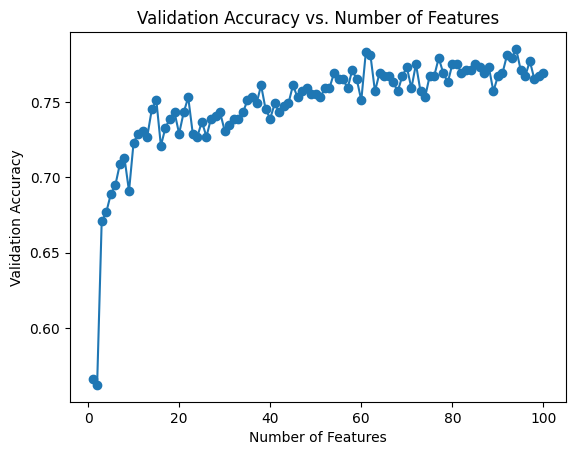

Optimal number of features: 94
10
Cross-validation results: [0.6281407  0.62562814 0.61055276 0.63065327 0.67002519]
Average Accuracy: 0.6330000126577472
Train Accuracy: 1.0
Test Accuracy: 0.6184738955823293


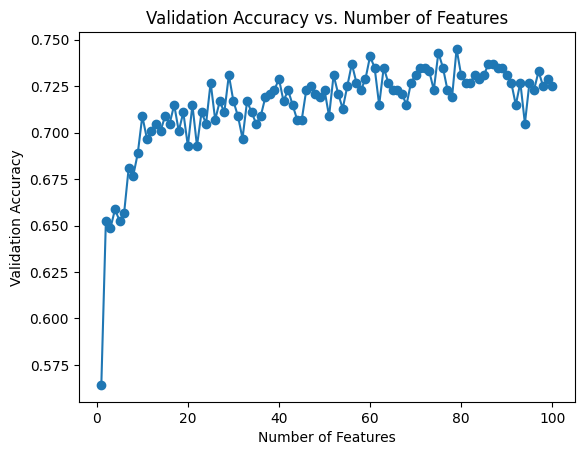

Optimal number of features: 79
11
Cross-validation results: [0.61306533 0.63567839 0.64572864 0.61055276 0.64735516]
Average Accuracy: 0.6304760578712201
Train Accuracy: 1.0
Test Accuracy: 0.6546184738955824


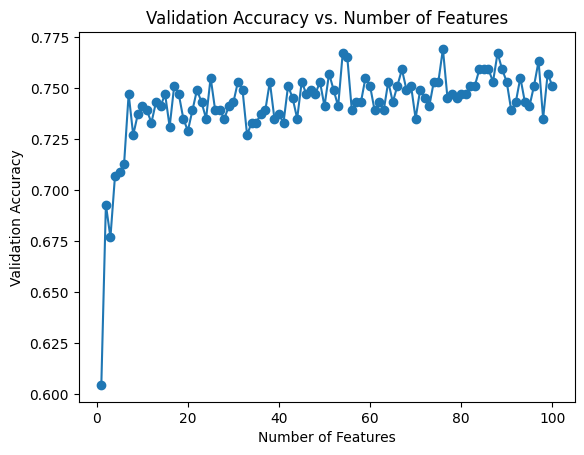

Optimal number of features: 76
12
Cross-validation results: [0.64321608 0.65075377 0.65829146 0.65326633 0.61964736]
Average Accuracy: 0.6450349986709365
Train Accuracy: 1.0
Test Accuracy: 0.6305220883534136


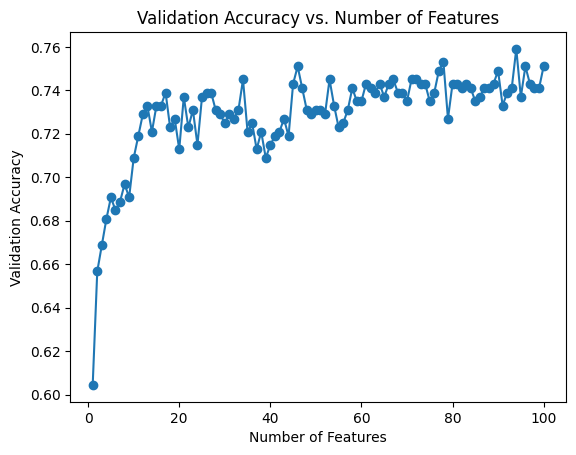

Optimal number of features: 94
13
Cross-validation results: [0.6281407  0.65577889 0.67336683 0.66582915 0.65994962]
Average Accuracy: 0.6566130400111388
Train Accuracy: 1.0
Test Accuracy: 0.6265060240963856


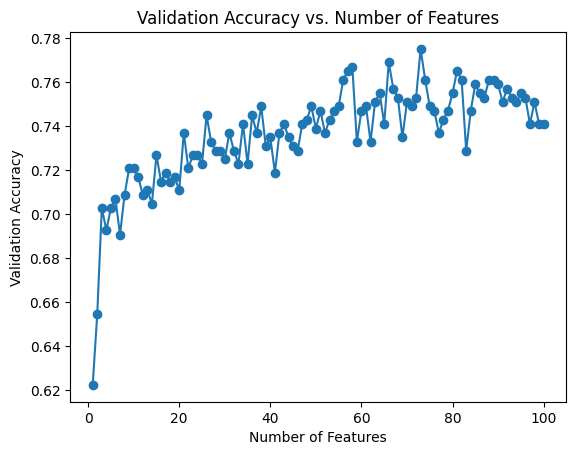

Optimal number of features: 73
14
Cross-validation results: [0.6959799  0.64070352 0.65075377 0.6281407  0.67758186]
Average Accuracy: 0.658631950685417
Train Accuracy: 1.0
Test Accuracy: 0.6385542168674698


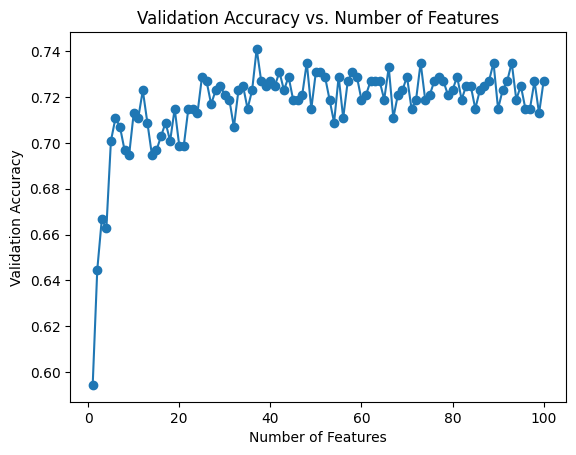

Optimal number of features: 37
15
Cross-validation results: [0.64070352 0.62060302 0.64321608 0.62311558 0.62216625]
Average Accuracy: 0.6299608875612319
Train Accuracy: 1.0
Test Accuracy: 0.6887550200803213


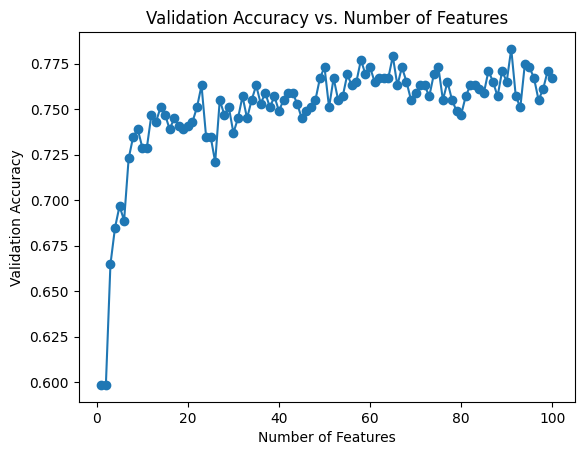

Optimal number of features: 91
16
Cross-validation results: [0.63065327 0.66080402 0.66331658 0.62060302 0.65239295]
Average Accuracy: 0.645553966305077
Train Accuracy: 1.0
Test Accuracy: 0.6807228915662651


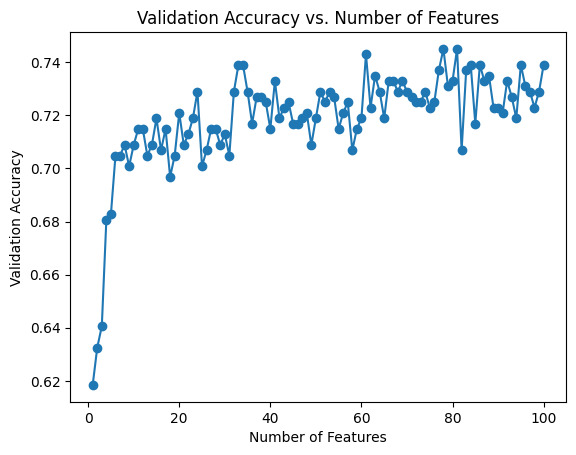

Optimal number of features: 78
17
Cross-validation results: [0.66080402 0.61306533 0.65577889 0.65326633 0.62720403]
Average Accuracy: 0.6420237206182043
Train Accuracy: 1.0
Test Accuracy: 0.6867469879518072


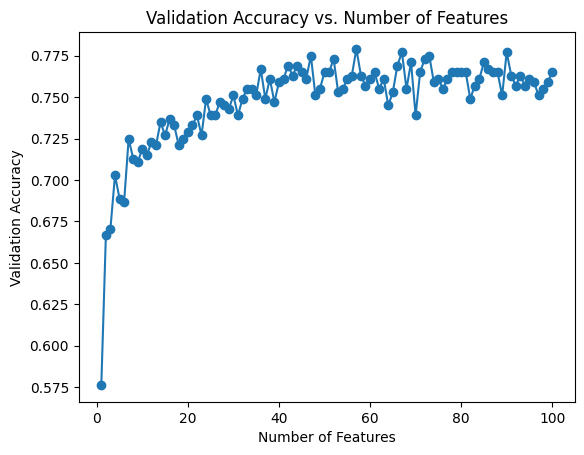

Optimal number of features: 57
18
Cross-validation results: [0.57788945 0.64824121 0.63567839 0.64824121 0.62972292]
Average Accuracy: 0.6279546346341277
Train Accuracy: 1.0
Test Accuracy: 0.6405622489959839


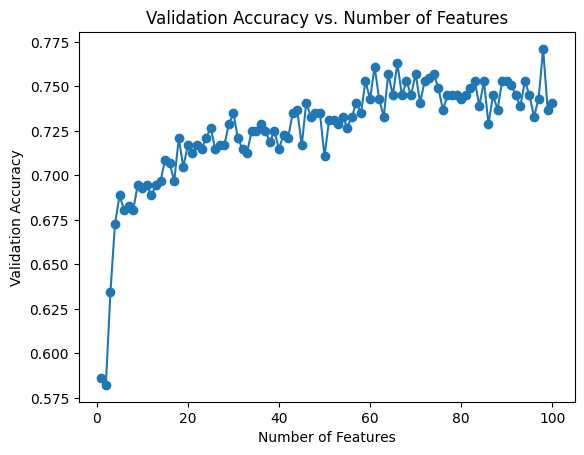

Optimal number of features: 98
19
Cross-validation results: [0.64572864 0.62060302 0.63819095 0.6758794  0.65491184]
Average Accuracy: 0.6470627697682366
Train Accuracy: 1.0
Test Accuracy: 0.6024096385542169


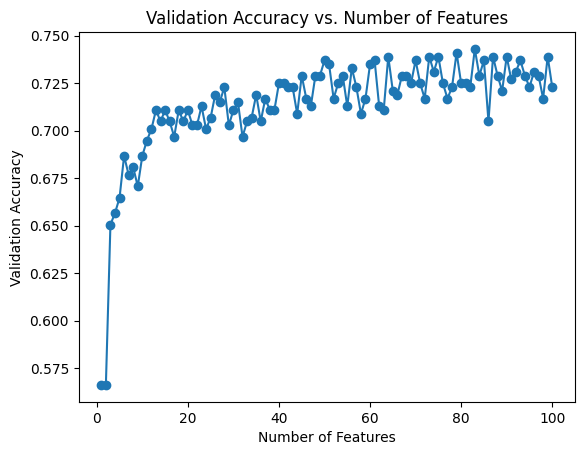

Optimal number of features: 83
20
Cross-validation results: [0.63567839 0.66331658 0.64572864 0.65326633 0.66498741]
Average Accuracy: 0.652595471058061
Train Accuracy: 1.0
Test Accuracy: 0.6224899598393574


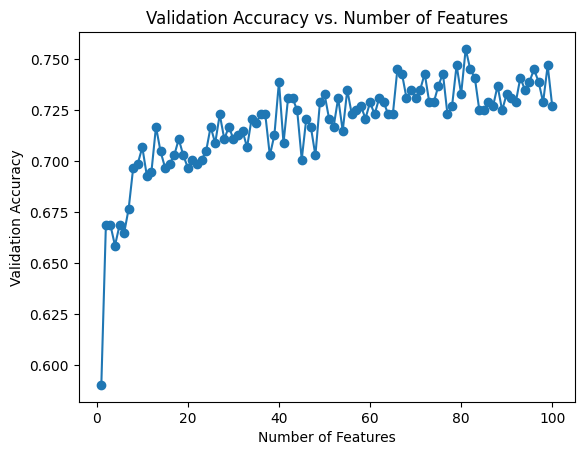

Optimal number of features: 81


In [87]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    dt_model = decision_tree(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = RF_find_best_num_features(X_train, y_train, X_test, y_test, dt_model)
    X_train_selected
    RF_Features_selection.append(X_train_selected.columns)

## SHAP Feature Selection

In [35]:
def xgboost_sort_features(model, X_train):
     # Create SHAP explainer and calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    # Calculate feature importance (mean absolute SHAP values)
    feature_importance = np.abs(shap_values).mean(0)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order of importance
    return sorted_idx

In [36]:
def tree_sort_features(model, X_train):       
    #  Create SHAP explainer for Random Forest
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

    # Compute SHAP difference (Class 1 - Class 0) and take mean absolute values
    shap_values_diff = shap_values[:, :, 1] - shap_values[:, :, 0]
    feature_importance = np.abs(shap_values_diff).mean(axis=0)  # Shape: (features,)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    return sorted_idx

In [14]:
def kernel_sort_features(model, X_train):
    # Create SHAP KernelExplainer (use a small sample for efficiency)
    explainer = shap.KernelExplainer(model.predict, X_train.sample(50))  # Sampling speeds up computation
    shap_values = explainer.shap_values(X_train)

    # Convert to NumPy array if not already
    shap_values = np.array(shap_values)  # Shape: (samples, features)

    # Compute feature importance (mean absolute SHAP values)
    feature_importance = np.abs(shap_values).mean(axis=0)  # Shape: (features,)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]  # Descending order
    return sorted_idx

In [89]:
SHAP_Feature_selection = []

In [90]:
def find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):
    #sorted_idx = xgboost_sort_features(model, X_train)
    sorted_idx = tree_sort_features(model, X_train)
    #sorted_idx = kernel_sort_features(model, X_train)
    
    validation_accuracies = []
    train_accuracies = []

    for num_features in range(1, max_features + 1):
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")

    selected_features = X_train.columns[sorted_idx[:optimal_num_features]]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

1
Cross-validation results: [0.65075377 0.65577889 0.64572864 0.63819095 0.56423174]
Average Accuracy: 0.6309367998683595
Train Accuracy: 1.0
Test Accuracy: 0.6606425702811245


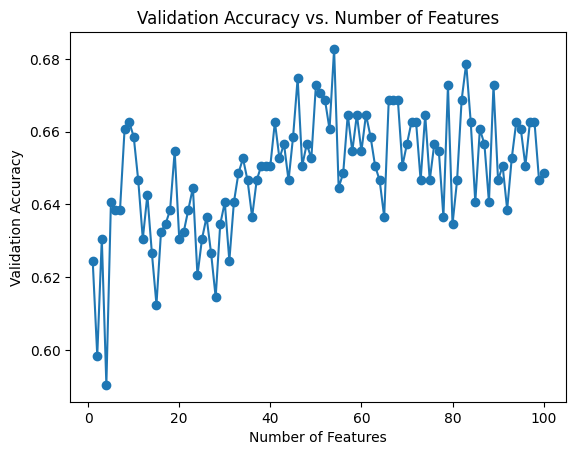

Optimal number of features: 54
2
Cross-validation results: [0.68844221 0.63567839 0.63065327 0.67085427 0.62720403]
Average Accuracy: 0.6505664341860435
Train Accuracy: 1.0
Test Accuracy: 0.6686746987951807


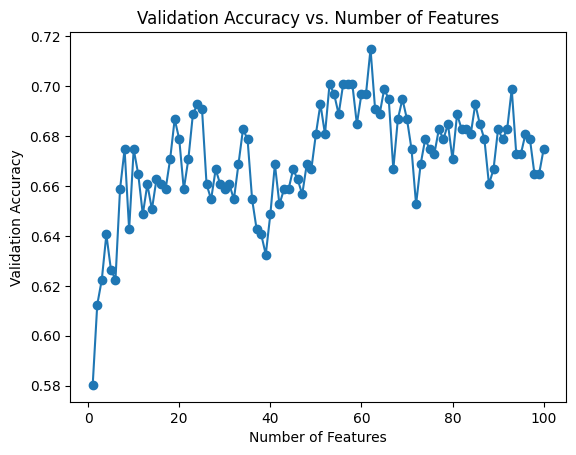

Optimal number of features: 62
3
Cross-validation results: [0.66582915 0.62311558 0.66582915 0.67839196 0.64483627]
Average Accuracy: 0.6556004202372062
Train Accuracy: 1.0
Test Accuracy: 0.6325301204819277


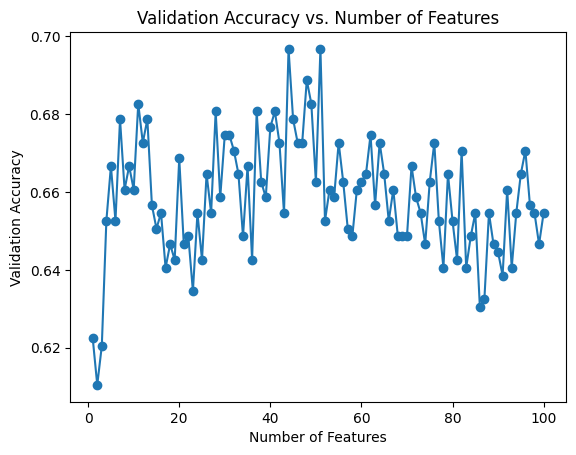

Optimal number of features: 44
4
Cross-validation results: [0.67085427 0.60301508 0.59547739 0.66331658 0.69269521]
Average Accuracy: 0.6450717061377417
Train Accuracy: 1.0
Test Accuracy: 0.6686746987951807


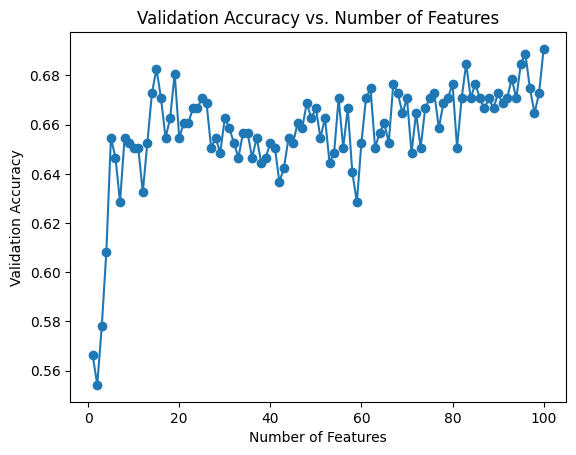

Optimal number of features: 100
5
Cross-validation results: [0.66080402 0.63065327 0.64321608 0.61055276 0.63224181]
Average Accuracy: 0.6354935888510563
Train Accuracy: 1.0
Test Accuracy: 0.6566265060240963


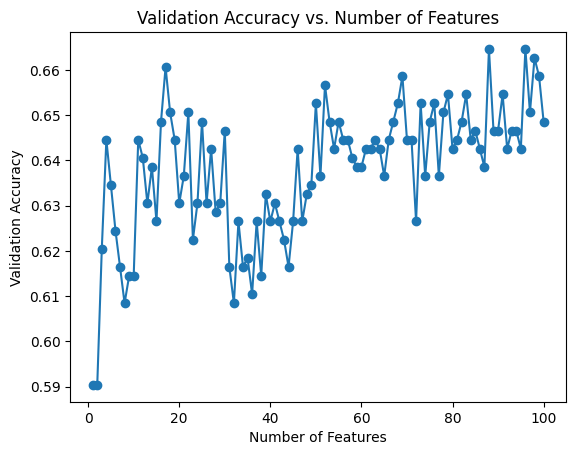

Optimal number of features: 88
6
Cross-validation results: [0.63316583 0.6080402  0.63567839 0.62562814 0.68010076]
Average Accuracy: 0.6365226636963153
Train Accuracy: 1.0
Test Accuracy: 0.6586345381526104


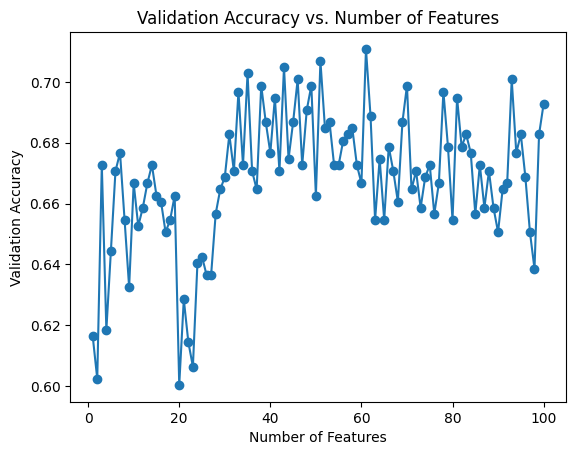

Optimal number of features: 61
7
Cross-validation results: [0.6281407  0.61809045 0.66331658 0.63567839 0.63476071]
Average Accuracy: 0.6359973671885878
Train Accuracy: 1.0
Test Accuracy: 0.6325301204819277


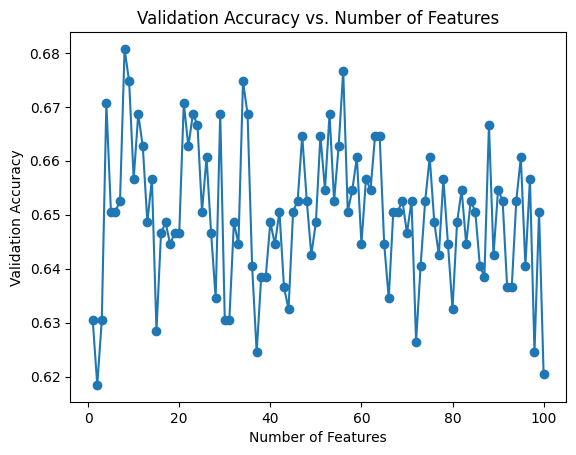

Optimal number of features: 8
8
Cross-validation results: [0.64572864 0.68090452 0.62311558 0.67336683 0.60453401]
Average Accuracy: 0.6455299165854461
Train Accuracy: 1.0
Test Accuracy: 0.6485943775100401


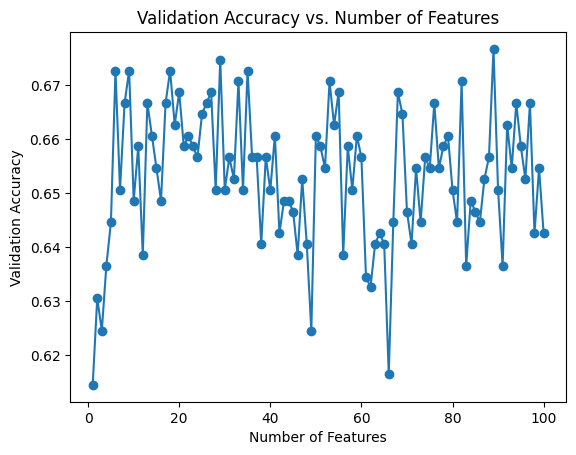

Optimal number of features: 89
9
Cross-validation results: [0.65577889 0.66080402 0.64572864 0.60050251 0.62216625]
Average Accuracy: 0.6369960634406289
Train Accuracy: 1.0
Test Accuracy: 0.6405622489959839


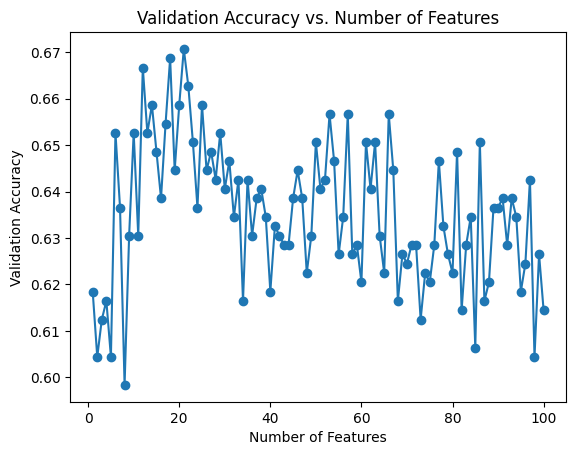

Optimal number of features: 21
10
Cross-validation results: [0.67336683 0.63819095 0.63819095 0.61809045 0.67506297]
Average Accuracy: 0.6485804336544183
Train Accuracy: 1.0
Test Accuracy: 0.6626506024096386


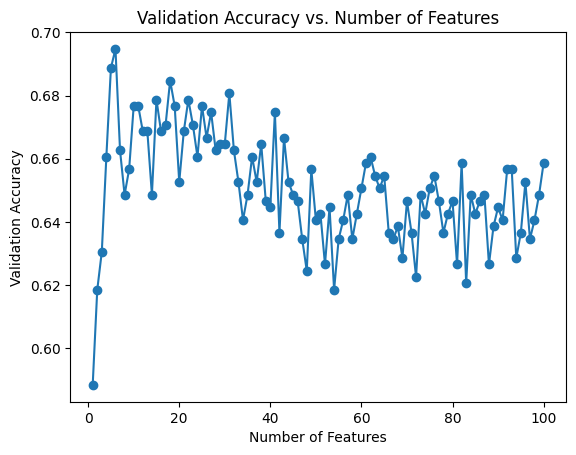

Optimal number of features: 6
11
Cross-validation results: [0.65577889 0.65075377 0.6758794  0.61557789 0.67254408]
Average Accuracy: 0.6541068060706555
Train Accuracy: 1.0
Test Accuracy: 0.6907630522088354


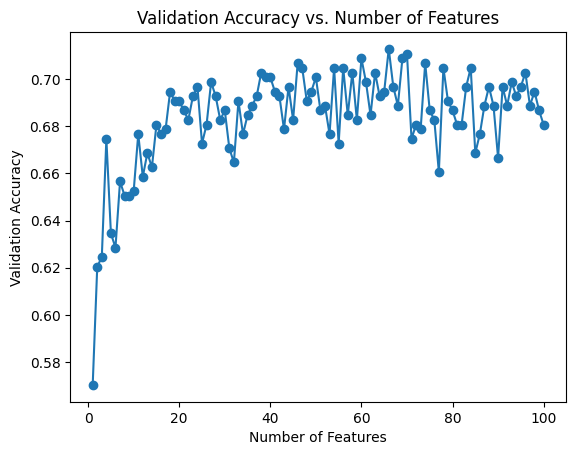

Optimal number of features: 66
12
Cross-validation results: [0.6281407  0.62311558 0.63567839 0.60301508 0.69269521]
Average Accuracy: 0.6365289925699025
Train Accuracy: 1.0
Test Accuracy: 0.6706827309236948


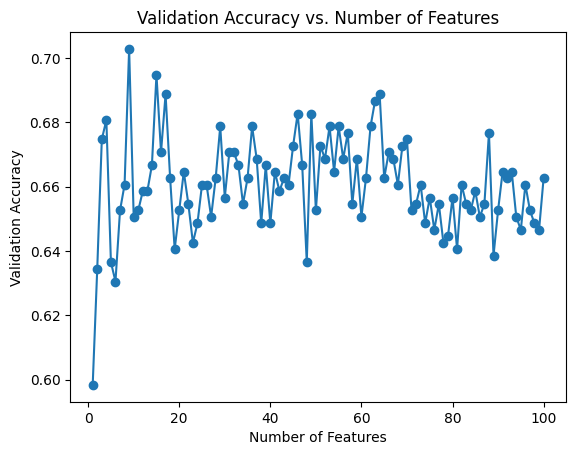

Optimal number of features: 9
13
Cross-validation results: [0.65075377 0.65326633 0.63567839 0.65075377 0.66498741]
Average Accuracy: 0.6510879333696189
Train Accuracy: 1.0
Test Accuracy: 0.6365461847389559


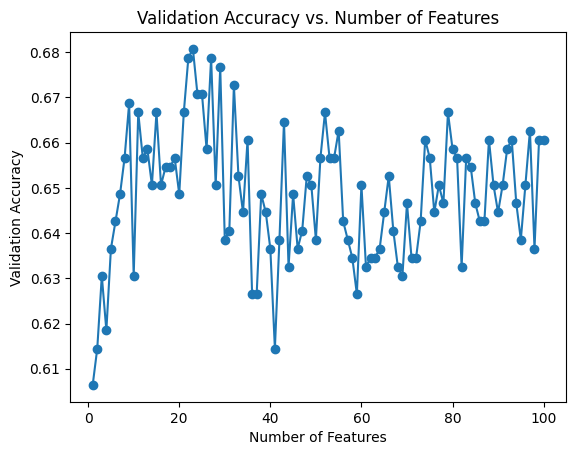

Optimal number of features: 23
14
Cross-validation results: [0.63819095 0.63819095 0.64572864 0.6281407  0.64735516]
Average Accuracy: 0.6395212840018734
Train Accuracy: 1.0
Test Accuracy: 0.6224899598393574


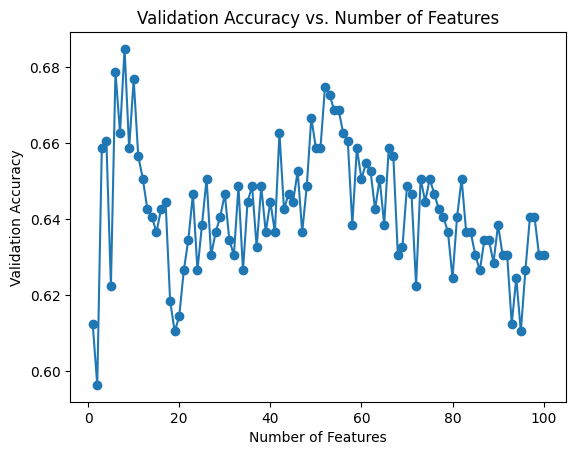

Optimal number of features: 8
15
Cross-validation results: [0.66080402 0.64321608 0.65326633 0.64321608 0.61712846]
Average Accuracy: 0.6435261952077769
Train Accuracy: 1.0
Test Accuracy: 0.6546184738955824


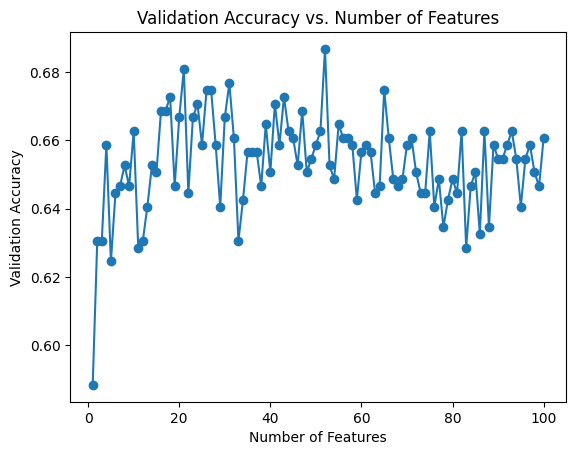

Optimal number of features: 52
16
Cross-validation results: [0.63819095 0.68341709 0.62311558 0.65829146 0.61460957]
Average Accuracy: 0.6435249294330595
Train Accuracy: 1.0
Test Accuracy: 0.6405622489959839


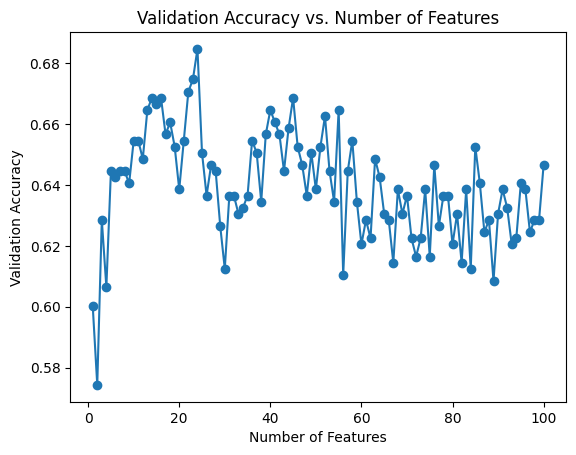

Optimal number of features: 24
17
Cross-validation results: [0.62562814 0.64321608 0.67839196 0.63567839 0.64987406]
Average Accuracy: 0.6465577256559878
Train Accuracy: 1.0
Test Accuracy: 0.6465863453815262


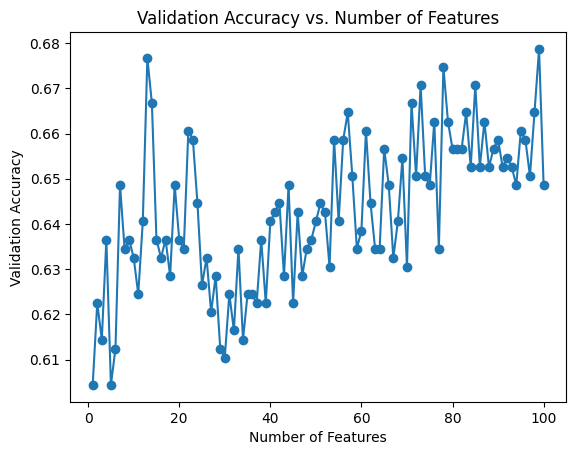

Optimal number of features: 99
18
Cross-validation results: [0.67336683 0.64572864 0.63819095 0.64070352 0.64231738]
Average Accuracy: 0.6480614660202777
Train Accuracy: 1.0
Test Accuracy: 0.6626506024096386


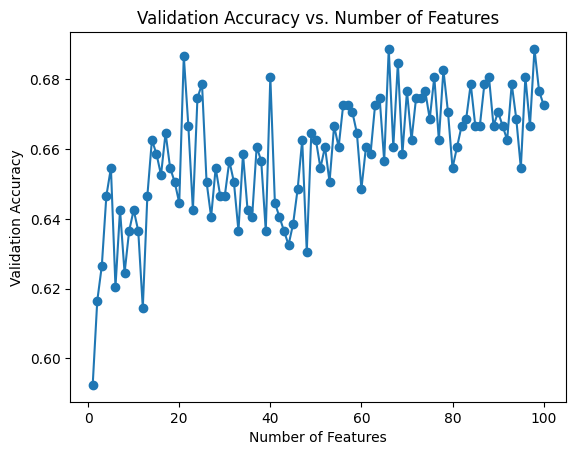

Optimal number of features: 66
19
Cross-validation results: [0.66582915 0.67839196 0.68592965 0.63065327 0.62972292]
Average Accuracy: 0.6581053884029722
Train Accuracy: 1.0
Test Accuracy: 0.6566265060240963


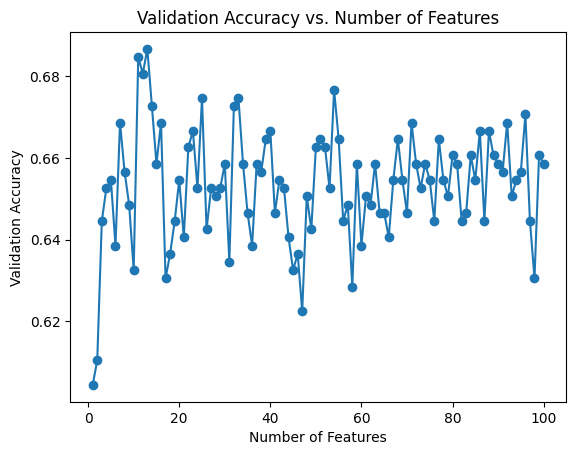

Optimal number of features: 13
20
Cross-validation results: [0.65326633 0.67336683 0.62562814 0.67085427 0.6070529 ]
Average Accuracy: 0.6460336949229777
Train Accuracy: 1.0
Test Accuracy: 0.6506024096385542


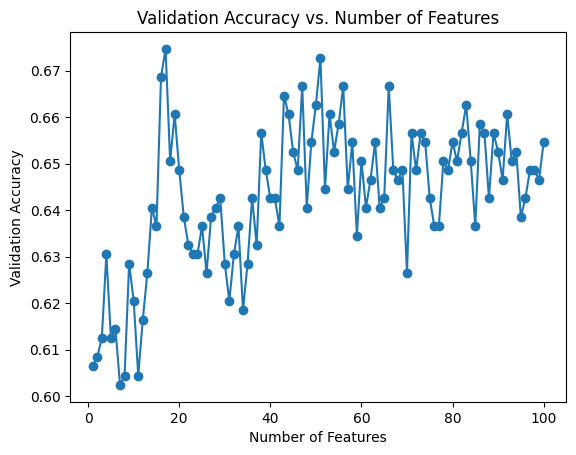

Optimal number of features: 17


In [91]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    dt_model = decision_tree(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = find_best_num_features(X_train, y_train, X_test, y_test, dt_model)
    X_train_selected
    SHAP_Feature_selection.append(X_train_selected)

## Selection

In [47]:

from collections import Counter
# Using list comprehension to flatten the list
features = [item for sublist in RF_Features_selection for item in sublist]
# Count occurrences of each feature
feature_counts = Counter(features)

print(feature_counts)


Counter({'MaxAbsEStateIndex': 20, 'MaxEStateIndex': 20, 'MinAbsEStateIndex': 20, 'MinEStateIndex': 20, 'qed': 20, 'SPS': 20, 'MolWt': 20, 'HeavyAtomMolWt': 20, 'ExactMolWt': 20, 'NumValenceElectrons': 20, 'MaxPartialCharge': 20, 'MinPartialCharge': 20, 'MaxAbsPartialCharge': 20, 'MinAbsPartialCharge': 20, 'FpDensityMorgan1': 20, 'FpDensityMorgan2': 20, 'FpDensityMorgan3': 20, 'AvgIpc': 20, 'BalabanJ': 20, 'BertzCT': 20, 'Chi0': 20, 'Chi0n': 20, 'Chi0v': 20, 'Chi1': 20, 'Chi1n': 20, 'Chi1v': 20, 'Chi2v': 20, 'Chi3n': 20, 'Chi3v': 20, 'Chi4n': 20, 'HallKierAlpha': 20, 'Ipc': 20, 'Kappa1': 20, 'Kappa2': 20, 'Kappa3': 20, 'LabuteASA': 20, 'PEOE_VSA1': 20, 'PEOE_VSA6': 20, 'SlogP_VSA2': 20, 'TPSA': 20, 'EState_VSA3': 20, 'VSA_EState5': 20, 'VSA_EState7': 20, 'VSA_EState8': 20, 'NOCount': 20, 'MolLogP': 20, 'MolMR': 20, 'Chi2n': 19, 'Chi4v': 19, 'VSA_EState3': 19, 'PEOE_VSA8': 18, 'SMR_VSA5': 18, 'EState_VSA8': 18, 'FractionCSP3': 18, 'SMR_VSA1': 17, 'EState_VSA4': 17, 'VSA_EState2': 17, 'PE

In [48]:
threshold = 19 # Minimum number of votes required
selected_features = [feature for feature, count in feature_counts.items() if count >= threshold]

print(len(selected_features))

50


### Voting of XGB feature names

In [33]:
XGB_feature_names_RFE_18 = [feature for feature, count in feature_counts.items() if count >= 18]
XGB_feature_names_RFE_17 = [feature for feature, count in feature_counts.items() if count >= 17]
XGB_feature_counts_RFE = feature_counts

In [35]:
XGB_feature_names_SHAP_20 = [feature for feature, count in feature_counts.items() if count >= 20]
XGB_feature_names_SHAP_19 = [feature for feature, count in feature_counts.items() if count >= 19]
XGB_feature_counts_SHAP = feature_counts

In [37]:
XGB_feature_names_RF_20 = [feature for feature, count in feature_counts.items() if count >= 20]
XGB_feature_names_RF_19 = [feature for feature, count in feature_counts.items() if count >= 19]
XGB_feature_counts_RF = feature_counts

In [39]:
XGB_feature_names_SHAP_20

['AvgIpc',
 'MaxAbsEStateIndex',
 'SlogP_VSA6',
 'PEOE_VSA6',
 'TPSA',
 'PEOE_VSA1',
 'EState_VSA3',
 'Kappa3',
 'VSA_EState3',
 'BalabanJ',
 'MinEStateIndex',
 'SPS',
 'SMR_VSA5',
 'HallKierAlpha',
 'VSA_EState7',
 'Kappa2',
 'Kappa1',
 'VSA_EState8',
 'SMR_VSA10',
 'EState_VSA4',
 'MinPartialCharge',
 'SlogP_VSA1']

In [40]:
All_methods = XGB_feature_names_RF_20 + XGB_feature_names_SHAP_20 + XGB_feature_names_RFE_18 + feature_names_Lasso

In [41]:
feature_counts = Counter(All_methods)

print(feature_counts)

Counter({'MaxAbsEStateIndex': 4, 'PEOE_VSA1': 4, 'TPSA': 4, 'AvgIpc': 3, 'Chi4v': 3, 'MinEStateIndex': 2, 'SPS': 2, 'MinPartialCharge': 2, 'MaxAbsPartialCharge': 2, 'FpDensityMorgan1': 2, 'BalabanJ': 2, 'Chi3n': 2, 'Chi4n': 2, 'HallKierAlpha': 2, 'Kappa1': 2, 'Kappa2': 2, 'Kappa3': 2, 'VSA_EState8': 2, 'SlogP_VSA6': 2, 'EState_VSA3': 2, 'SMR_VSA5': 2, 'VSA_EState7': 2, 'SlogP_VSA1': 2, 'MinAbsEStateIndex': 1, 'MolWt': 1, 'NumValenceElectrons': 1, 'MaxPartialCharge': 1, 'BertzCT': 1, 'Chi1v': 1, 'Chi2v': 1, 'Chi3v': 1, 'Ipc': 1, 'SlogP_VSA2': 1, 'MolLogP': 1, 'PEOE_VSA6': 1, 'VSA_EState3': 1, 'SMR_VSA10': 1, 'EState_VSA4': 1, 'PEOE_VSA13': 1, 'PEOE_VSA4': 1, 'SMR_VSA3': 1, 'VSA_EState6': 1, 'EState_VSA1': 1, 'NOCount': 1, 'NumHeteroatoms': 1, 'NumRotatableBonds': 1, 'fr_C_O_noCOO': 1, 'fr_ether': 1})


In [47]:

selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

print(len(selected_features))
print(selected_features)

23
['MaxAbsEStateIndex', 'MinEStateIndex', 'SPS', 'MinPartialCharge', 'MaxAbsPartialCharge', 'FpDensityMorgan1', 'AvgIpc', 'BalabanJ', 'Chi3n', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'Kappa3', 'PEOE_VSA1', 'TPSA', 'VSA_EState8', 'SlogP_VSA6', 'EState_VSA3', 'SMR_VSA5', 'VSA_EState7', 'SlogP_VSA1']


### Voting Random forest

In [49]:
RF_feature_names_RFE_20 = [feature for feature, count in feature_counts.items() if count >= 20]
RF_feature_names_RFE_19 = [feature for feature, count in feature_counts.items() if count >= 19]
RF_feature_counts_RFE = feature_counts

In [45]:
RF_feature_names_SHAP_20 = [feature for feature, count in feature_counts.items() if count >= 20]
RF_feature_names_SHAP_19 = [feature for feature, count in feature_counts.items() if count >= 19]
RF_feature_counts_SHAP = feature_counts

In [42]:
RF_feature_names_RF_20 = [feature for feature, count in feature_counts.items() if count >= 20]
RF_feature_names_RF_19 = [feature for feature, count in feature_counts.items() if count >= 19]
RF_feature_counts_RF = feature_counts

In [53]:
RF_All_methods = RF_feature_names_RF_20 + RF_feature_names_RFE_20 + RF_feature_names_SHAP_20 + feature_names_Lasso

In [54]:
RF_All_methods

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA6',
 'SlogP_VSA2',
 'TPSA',
 'EState_VSA3',
 'VSA_EState5',
 'VSA_EState7',
 'VSA_EState8',
 'NOCount',
 'MolLogP',
 'MolMR',
 'MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'Avg

In [66]:
feature_counts = Counter(RF_All_methods)

print(feature_counts)

Counter({'MaxAbsEStateIndex': 4, 'MaxEStateIndex': 4, 'MaxAbsPartialCharge': 4, 'PEOE_VSA1': 4, 'TPSA': 4, 'NOCount': 4, 'NumValenceElectrons': 3, 'MinPartialCharge': 3, 'MinAbsPartialCharge': 3, 'FpDensityMorgan1': 3, 'AvgIpc': 3, 'Chi0n': 3, 'Chi1': 3, 'Chi3n': 3, 'Chi4n': 3, 'Kappa1': 3, 'EState_VSA3': 3, 'MinAbsEStateIndex': 2, 'MinEStateIndex': 2, 'qed': 2, 'SPS': 2, 'MolWt': 2, 'HeavyAtomMolWt': 2, 'ExactMolWt': 2, 'MaxPartialCharge': 2, 'FpDensityMorgan2': 2, 'FpDensityMorgan3': 2, 'BalabanJ': 2, 'BertzCT': 2, 'Chi0': 2, 'Chi0v': 2, 'Chi1n': 2, 'Chi1v': 2, 'Chi2v': 2, 'Chi3v': 2, 'HallKierAlpha': 2, 'Ipc': 2, 'Kappa2': 2, 'Kappa3': 2, 'LabuteASA': 2, 'PEOE_VSA6': 2, 'SlogP_VSA2': 2, 'VSA_EState5': 2, 'VSA_EState7': 2, 'VSA_EState8': 2, 'MolLogP': 2, 'MolMR': 2, 'HeavyAtomCount': 1, 'Chi4v': 1, 'SMR_VSA5': 1, 'SlogP_VSA1': 1, 'EState_VSA1': 1, 'NumHeteroatoms': 1, 'NumRotatableBonds': 1, 'fr_C_O_noCOO': 1, 'fr_ether': 1})


In [69]:

selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

print(len(selected_features))
print(selected_features)

47
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA6', 'SlogP_VSA2', 'TPSA', 'EState_VSA3', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'NOCount', 'MolLogP', 'MolMR']


## Save Selected Features

In [63]:
selected_features = RF_feature_names_SHAP_20

In [64]:
selected_features

['AvgIpc',
 'MaxEStateIndex',
 'NumValenceElectrons',
 'MaxAbsEStateIndex',
 'TPSA',
 'NOCount',
 'PEOE_VSA1',
 'Kappa1',
 'Chi1',
 'Chi0n',
 'MinAbsPartialCharge',
 'HeavyAtomCount',
 'MaxAbsPartialCharge',
 'MinPartialCharge']

In [70]:
#selected_features = list(X_train_selected.columns)
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/selected_features_RF_voting2.xlsx", index=False)

## Testing features

In [71]:
df1 = pd.read_excel("Features/Large/selected_features_RF_RF.xlsx")
df2 = pd.read_excel("Features/Large/selected_features_RF_SHAP.xlsx")
df3 = pd.read_excel("Features/Large/selected_features_RF_RFE.xlsx")
df4 = pd.read_excel("Features/Large/selected_features_RF_voting2.xlsx")
df5 = pd.read_excel("Features/Large/selected_features_RF_voting3.xlsx")
df6 = pd.read_excel("Features/Large/selected_features_Lasso.xlsx")
df7 = pd.read_excel("Features/Large/selected_features_CorrVar.xlsx")

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have 5 datasets stored as Pandas DataFrames
datasets = {
    "Dataset RF": df1,
    "Dataset SHAP": df2,
    "Dataset RFE": df3,
    "Dataset voting2": df4,
    "Dataset voting3": df5,
    "Dataset Lasso": df6,
    "Dataset CorrVar": df7,
}

num_runs = 25
kf = KFold(n_splits=5, shuffle=True, random_state=None)  # 5-fold CV

results = {name: {"train_acc": [], "test_acc": [], "cv_acc": []} for name in datasets}

# Loop through each dataset
for name, df in datasets.items():
    X = df.drop(columns="Irritation") # All columns except the last one as features
    y = df["Irritation"]   # Last column as target

    for _ in range(num_runs):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
        
        # Train model
        model = RandomForestClassifier(n_estimators=100, random_state=None)
        #model = xgb.XGBClassifier(objective='binary:logistic')
        model.fit(X_train, y_train)
        
        # Evaluate on train & test
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))

        # Cross-validation accuracy
        cv_acc = np.mean(cross_val_score(model, X, y, cv=kf, scoring="accuracy"))

        # Store results
        results[name]["train_acc"].append(train_acc)
        results[name]["test_acc"].append(test_acc)
        results[name]["cv_acc"].append(cv_acc)



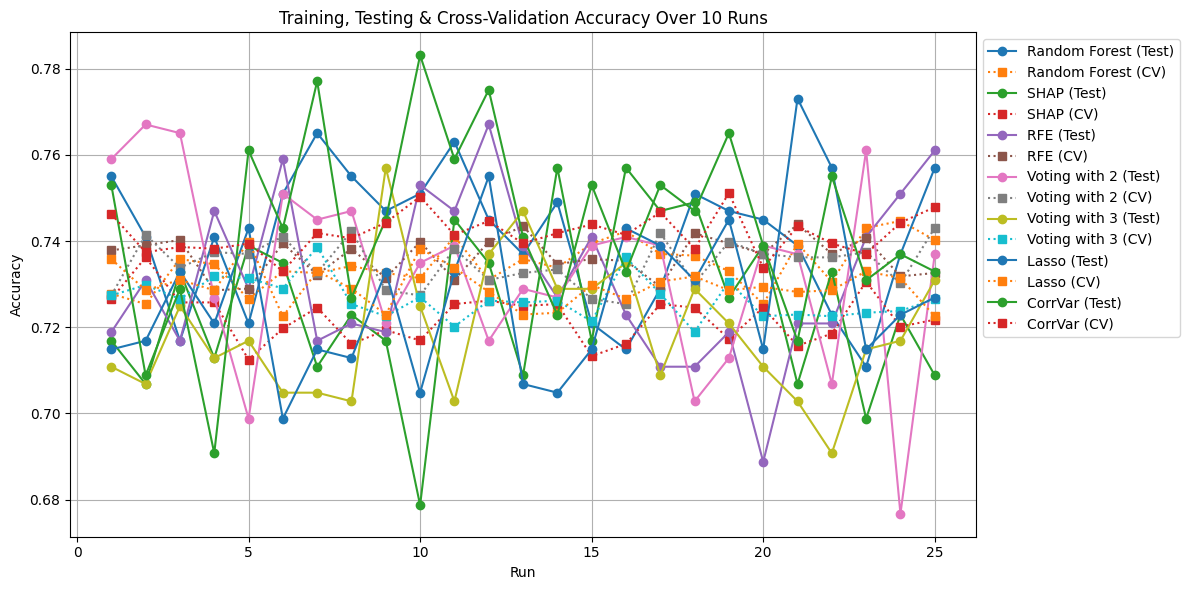

In [74]:
# Define new names for the datasets
new_labels = ["Random Forest", "SHAP", "RFE", "Voting with 2", "Voting with 3", "Lasso", "CorrVar"]

plt.figure(figsize=(12, 6))

# Loop through results and assign new names
for name, new_label in zip(results.keys(), new_labels):
    #plt.plot(range(1, num_runs + 1), results[name]["train_acc"], linestyle="dashed", label=f"{new_label} (Train)")
    plt.plot(range(1, num_runs + 1), results[name]["test_acc"], marker="o", label=f"{new_label} (Test)")
    plt.plot(range(1, num_runs + 1), results[name]["cv_acc"], marker="s", linestyle="dotted", label=f"{new_label} (CV)")

plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.title("Training, Testing & Cross-Validation Accuracy Over 10 Runs")
plt.grid()

# Move legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Moves the legend outside

plt.tight_layout()  # Adjusts layout so nothing is cut off
plt.show()


In [75]:
# Compute average accuracy across the 10 runs
average_results = {}

for name in results.keys():
    avg_train = np.mean(results[name]["train_acc"])
    avg_test = np.mean(results[name]["test_acc"])
    avg_cv = np.mean(results[name]["cv_acc"])
    average_results[name] = {"Train": avg_train, "Test": avg_test, "CV": avg_cv}

# Sort models based on Cross-Validation Accuracy (CV)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]["CV"], reverse=True)

# Define new labels
new_labels = ["Random Forest", "SHAP", "RFE", "Voting with 2", "Voting with 3", "Lasso", "CorrVar"]
name_mapping = dict(zip(results.keys(), new_labels))

# Print sorted results
print("\nOrdered List of Models by Cross-Validation Accuracy")
print("-" * 50)
for rank, (name, scores) in enumerate(sorted_results, 1):
    print(f"{rank}. {name_mapping[name]} - Train: {scores['Train']:.4f}, Test: {scores['Test']:.4f}, CV: {scores['CV']:.4f}")



Ordered List of Models by Cross-Validation Accuracy
--------------------------------------------------
1. CorrVar - Train: 1.0000, Test: 0.7431, CV: 0.7418
2. RFE - Train: 1.0000, Test: 0.7312, CV: 0.7364
3. Voting with 2 - Train: 1.0000, Test: 0.7328, CV: 0.7347
4. Random Forest - Train: 1.0000, Test: 0.7405, CV: 0.7347
5. Lasso - Train: 1.0000, Test: 0.7270, CV: 0.7295
6. Voting with 3 - Train: 1.0000, Test: 0.7189, CV: 0.7266
7. SHAP - Train: 1.0000, Test: 0.7250, CV: 0.7221
